To Do:
- add MD cells summarizing results

# Examining crevasses on George VI Ice Shelf
By Emily Glazer

Research Computing for Earth Science, Fall 2021

## Part I: Research questions

Crevasses in ice shelves are deep cracks or fissures that can form as a result of shear stress generated by glacier movement. Basal crevasses are located on the bottom of ice shelves, i.e. at the ice-ocean interface, and surface crevasses are located at the top, i.e. at the air-ice interface. 

It is important to study crevasses because of their implications for glacier thinning and ice mass loss. A major cause of mass loss in ice shelves is $\textit{calving}$; this is when large pieces of the ice shelf break off and shed into the surrounding ocean. A precursor to calving is ice shelf $\textit{rifting}$, or fracturing that penetrates the entire thickness of the ice. Rifting occurs as a result of both basal and surface crevassing, and is even more likely in regions where there is both.

In 2017, McGrath et al. published a paper on "[Basal crevasses and associated surface crevassing on the Larsen C ice shelf](https://www.cambridge.org/core/journals/annals-of-glaciology/article/basal-crevasses-and-associated-surface-crevassing-on-the-larsen-c-ice-shelf-antarctica-and-their-role-in-iceshelf-instability/667E11CDAFCED09603BBF04625466FE1)" in $\textit{Annals of Glaciology}$, in which they observed that surface crevasses on the Larsen C ice shelf often exist directly above basal crevasses. McGrath suggests that the basal crevases form first and induce surface crevassing by creating a bending stress as they propagate.

For this project, I was curious to see if the George VI Ice Shelf (GVIIS) is in a similarly precarious position. GVIIS is one of the largest and fastest melting ice shelves on the Antarctic Peninsula; it is ~24,000km$^2$ in area and has been thinning at a rate of ~6m/yr since the 1990s. I set out to answer the following question: What is the relationship between the locations of basal crevasses and surface crevasses on GVIIS?

## Part II: George VI Ice Shelf

We will start by importing the usual Python libraries, and using Cartopy to look at GVIIS.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import xarray as xr
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (12,6)

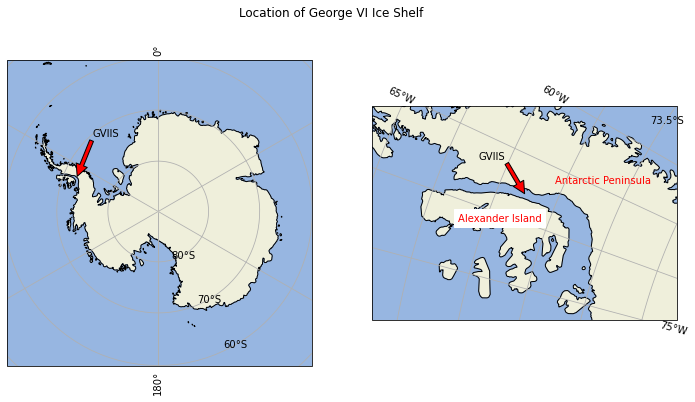

In [2]:
proj = ccrs.SouthPolarStereo(true_scale_latitude=-71)

fig=plt.figure()
ax0=fig.add_subplot(1,2,1,projection=proj)
ax1=fig.add_subplot(1,2,2,projection=proj)

for ax in [ax0,ax1]:
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.gridlines(draw_labels=True)
    
Ant_extent=[-180,180,-89,-60]
GVIIS_extent=[-75,-65,-75,-68]

ax0.set_extent(Ant_extent,ccrs.PlateCarree())
ax1.set_extent(GVIIS_extent,ccrs.PlateCarree())

transform=ccrs.PlateCarree()._as_mpl_transform(ax0)
ax0.annotate('GVIIS',xy=(.23,.62),xycoords='axes fraction',xytext=(.28,.75),textcoords='axes fraction',
            arrowprops=dict(facecolor='red'))
ax1.annotate('GVIIS',xy=(.5,.59),xycoords='axes fraction',xytext=(.35,.75),textcoords='axes fraction',
            arrowprops=dict(facecolor='red'))
ax1.annotate('Alexander Island',xy=(.28,.46),xycoords='axes fraction',color='red',BackgroundColor='white')
ax1.annotate('Antarctic Peninsula',xy=(.6,.64),xycoords='axes fraction',color='red')

fig.suptitle('Location of George VI Ice Shelf');

Cartopy does not have an "ice shelves" feature to display here, but GVIIS is the region bounded between Alexander Island and the mainland of the Antarctic Peninsula.

## Part III: CReSIS radar data
CReSIS (Center for the Remote Sensing of Ice Sheets) has collected radar data from all over Antarctica, and has made it open source [here](https://data.cresis.ku.edu/data/rds/). Radar data is collected from flights which send out and receive back radar waves along their trajectory. A received wave with high power indicates a "reflector" at that depth, i.e. a change in the dielectric of the medium. Reflectors can indicate the surface of the ice shelf (air-ice interface), bottom of the ice shelf (ice-ocean interface), or internal ice layers.

The CReSIS radar data is provided in the form of .mat files, each of which contains data from one 50km segment of a flight path. There is one flight trajectory in particular, from 2011, which flew all the way across GVIIS. I read in the nine .mat files associated with this flight path as hdf5 files using Pooch, then stored them in XArray datasets.

In [60]:
import pooch
import h5py
import re
from scipy.io import loadmat

In [61]:
base_url = "https://data.cresis.ku.edu/data/rds/"

registry={
        "2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_001.mat":None,
        "2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_002.mat":None,
        "2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_003.mat":None,
        "2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_004.mat":None,
        "2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_005.mat":None,
        "2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_006.mat":None,
        "2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_007.mat":None,
        "2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_008.mat":None,
        "2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_009.mat":None,
    }

POOCH = pooch.create(
    path=pooch.os_cache(""),
    base_url=base_url,
    registry=registry
)

The following variables were included in the source .mat files:
- slow_time: in seconds, time elapsed since beginning of flight
- fast_time: in seconds, for each slow time, time elapsed since beginning of each transmit event
- latitude
- longitude
- elevation: elevation of flight above earth's surface (not surface elevation)
- data: received power from each transmit event, in W/m^2

The following variables, I calculated and assigned to each dataset:
- dist_along_path: distance along the 50km flight path
- log_data: received power from each transmit event, in decibels
    - calculated as: $10 \times log_{10}(data)$
- depth: radar penetration depth, in meters
    - calculated as: $elevation - (fast\_time \times \frac{c}{2})$
- lat_lon: string expressing location coordinates, to display on plot

The data from flight paths from different years is formatted differently; newer datasets are able to be read in immediately as h5 files, whereas older ones need to be loaded as .mat files. The function below handles this discrepancy, then for both types, extracts the variables and coordinates as data frames, calculates the new variables described above, and constructs an Xarray dataset.

In [5]:
def get_data_from_file(fname):
    try:
        imported_data = h5py.File(fname)
        for k2,v2 in imported_data.items():
            arrays[k2]=np.array(v2)
    except OSError:
        imported_data = loadmat(fname)
        for k2,v2 in imported_data.items():
            if(k2!='Time'):
                if(len(np.shape(v2))==2):
                    imported_data[k2]=np.swapaxes(v2,0,1)
            arrays[k2]=np.array(imported_data[k2])
    data_vars={'data':(['slow_time','fast_time'],arrays.get('Data'))}
    coords={
        'slow_time':arrays.get('GPS_time').flatten(),
        'fast_time':arrays.get('Time').flatten(),
        'latitude':(['slow_time'],arrays.get('Latitude').flatten()),
        'longitude':(['slow_time'],arrays.get('Longitude').flatten()),
        'elevation':(['slow_time'],arrays.get('Elevation').flatten()),
    }
    dataset=xr.Dataset(
        data_vars=data_vars,
        coords=coords
    )
    num_locs=len(dataset.slow_time.values)
    frame_spacing=frame_dist / num_locs
    dataset=dataset.assign_coords(number=np.arange(num_locs))
    dataset=dataset.assign_coords({'dist_along_path':('slow_time',frame_spacing * dataset.number.data)})
    lat_lon=np.array([])
    for i in np.arange(len(dataset.latitude.values)):
        lat=round(dataset.latitude.values[i],2)
        lon=round(dataset.longitude.values[i],2)
        new_val='('+str(lat)+', '+str(lon)+')'
        lat_lon=np.append(lat_lon,new_val)
    dataset=dataset.assign_coords({'lat_lon':('slow_time',lat_lon)})
    dataset=dataset.drop_dims('number')
    dataset=dataset.assign(log_data=lambda dataset: 10 * np.log10(dataset.data))
    dataset=dataset.assign_coords(depth=lambda dataset: dataset.elevation - dataset.fast_time * c/2)
    return dataset

In [63]:
c=3e8 # speed of light, m/s
frame_dist=50 # distance traveled within each flight path, km

datasets={}

for k1,v1 in registry.items():
    arrays = {}
    dataset = get_data_from_file(POOCH.fetch(str(k1)))
    key=k1.replace('.mat','');key=key.replace('/CSARP_mvdr/','');key=key.replace('Antarctica_','')
    key=re.sub(r"/Data.*?20.{9}","",key)
    datasets[key]=dataset

We can now look at the list of all the dataset names, and an example of one of them. The naming convention is as follows:

[YYYY]\_[type of radar instrument]\[YYYY][MM][DD]\_[flight id number]_[segment id number]

In [64]:
name_list=list(datasets)
dataset_list=list(datasets.values())
print(name_list)

print(name_list[0])
dataset_list[0]

['2011_DC820111119_03_001', '2011_DC820111119_03_002', '2011_DC820111119_03_003', '2011_DC820111119_03_004', '2011_DC820111119_03_005', '2011_DC820111119_03_006', '2011_DC820111119_03_007', '2011_DC820111119_03_008', '2011_DC820111119_03_009']
2011_DC820111119_03_001


<xarray.Dataset>
Dimensions:          (slow_time: 1699, fast_time: 673)
Coordinates:
  * slow_time        (slow_time) float64 1.322e+09 1.322e+09 ... 1.322e+09
  * fast_time        (fast_time) float64 -1.001e-06 -8.956e-07 ... 6.982e-05
    latitude         (slow_time) float64 -69.94 -69.94 -69.94 ... -70.39 -70.39
    longitude        (slow_time) float64 -68.77 -68.77 -68.77 ... -68.45 -68.45
    elevation        (slow_time) float64 462.1 462.1 462.1 ... 466.9 466.8 466.7
    dist_along_path  (slow_time) float64 0.0 0.02943 0.05886 ... 49.94 49.97
    lat_lon          (slow_time) <U32 '(-69.94, -68.77)' ... '(-70.39, -68.45)'
    depth            (slow_time, fast_time) float64 612.2 596.4 ... -1.001e+04
Data variables:
    data             (slow_time, fast_time) float32 6.388e-15 ... 1.993e-22
    log_data         (slow_time, fast_time) float32 -141.9 -138.3 ... -217.0

The plot below shows the trajectory of the 2011 flight path we are interested in.

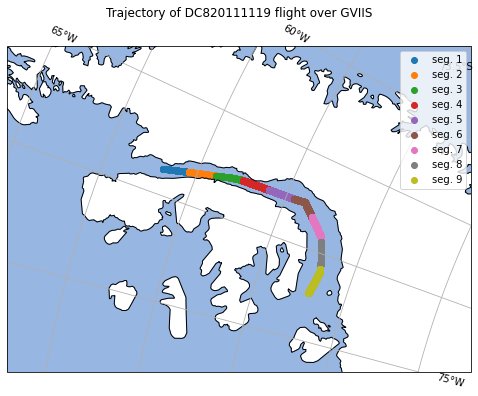

In [8]:
fig=plt.figure()
ax=fig.add_subplot(projection=proj)

ax.set_extent(GVIIS_extent,ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.OCEAN)

for index in np.arange(len(dataset_list)):
    dataset=dataset_list[index]
    label="seg. " + str(index+1)
    dataset.plot.scatter('longitude','latitude',transform=ccrs.PlateCarree(),ax=ax,label=label)
    
ax.legend()
ax.set_title('Trajectory of DC820111119 flight over GVIIS');

For the remainder of the project, I will focus on segments 6 through 9. I chose this subset because segment 1 is only partially over GVIIS (mostly over ocean), and segments 2 through 5 have very noisy data, which is likely due to their proximities to the grounding lines.

Now, we will examine the radar echogram plot for segment 9. The function below plots the radar data for a given segment number.

In [65]:
def plot_radar_data(segment_num, ax, processing=True):
    index=segment_num-1
    name=name_list[index]
    dataset=dataset_list[index]                     
    if(processing):
        ax.set_ylim(-5000,0)
        dataset = dataset.where((dataset['depth'] >= -5000) & (dataset['depth'] < 0))
        robust=True
    else:
        robust=False
    dataset.log_data.plot(x='dist_along_path',y='depth',ax=ax,cmap='inferno',
                          cbar_kwargs={'label':'received power (dB)'},
                          robust=robust)
    ax.set_xlabel('distance along flight path (km)')
    ax.set_xticks(np.arange(0,51,10))
    ax.set_ylabel('depth (m)')
    
    # adding (lat,lon) labels on secondary axis
    secax=ax.twiny()
    indices=np.append(np.arange(0,len(dataset.lat_lon.values),round(len(dataset.lat_lon.values)/5)),len(dataset.latitude.values)-1)
    secax.set_xticklabels(dataset.lat_lon.values[indices],fontdict={'fontsize':'small'})
    secax.set_xlabel('lat,lon (degrees)');
    return name

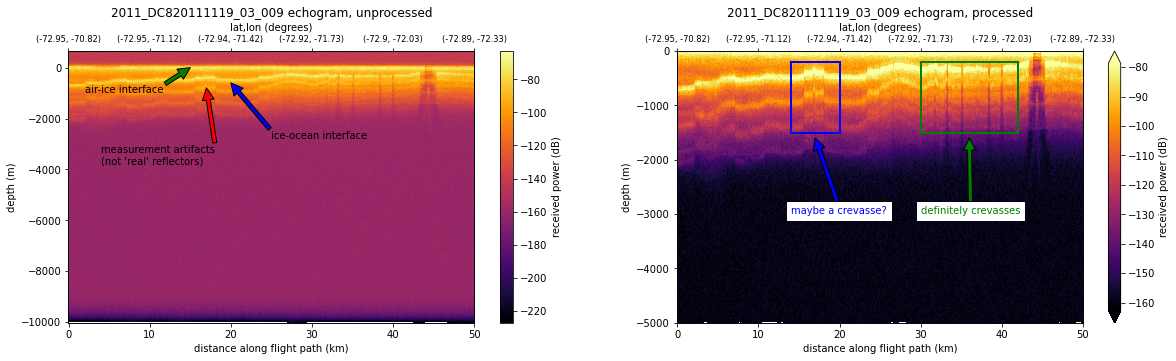

In [74]:
fig=plt.figure(figsize=(20,5))
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

name_0=plot_radar_data(9,ax0,processing=False)
name_1=plot_radar_data(9,ax1,processing=True)

ax0.set_title(name_0 + ' echogram, unprocessed')
ax0.annotate('air-ice interface',xy=(15,0),xytext=(2,-1000),arrowprops=dict(facecolor='green'))
ax0.annotate('ice-ocean interface',xy=(20,-600),xytext=(25,-2800),arrowprops=dict(facecolor='blue'))
ax0.annotate('measurement artifacts\n(not \'real\' reflectors)',xy=(17,-800),xytext=(4,-3800),arrowprops=dict(facecolor='red'))

ax1.set_title(name_1 + ' echogram, processed')
rect_def=patches.Rectangle((30,-1500),12,1300,edgecolor='green',facecolor='none',linewidth=2)
rect_maybe=patches.Rectangle((14,-1500),6,1300,edgecolor='blue',facecolor='none',linewidth=2)
ax1.add_patch(rect_def)
ax1.add_patch(rect_maybe)
ax1.annotate('definitely crevasses',xy=(36,-1600),
             color='green',BackgroundColor='white',
             xytext=(30,-3000),arrowprops=dict(facecolor='green'))
ax1.annotate('maybe a crevasse?',xy=(17,-1600),
             color='blue',BackgroundColor='white',
             xytext=(14,-3000),arrowprops=dict(facecolor='blue'));

The above figures show the same echogram twice: once before processing, and once after.

On the unprocessed echogram, I've pointed out the following:
- The air-ice interface: The radar instruments are $\textit{not}$ good at picking up the depth of the air-ice interface line with any level of precision, partly because they are not calibrated to do so, and partly because the variability of surface height is relatively low. This line looks almost completely flat on all the echograms I am using, and is not useful, for our purposes.
- $\textbf{The ice-ocean interface}$: This is the most important feature to identify on each echogram. It shows us the profile of the bottom of the ice shelf.
- Measurement artifacts: The lines below the ice-ocean interface that run almost completely parallel to it are just artifacts of the measurement, so are also not useful for our purposes.

In order to make our most important line, the ice-ocean interface, clearer, I did two simple processing steps:
1. I cut out values from the dataset that are below a depth of -5000m (well below any relevant signal) or above 0m (because we're not looking at surface data here). This improves the color bar scale and allows us to zoom in more closely on the relevant portion of the data.
1. I added the plotting parameter "robust=True", which prevents outliers from influencing the color scale by setting the 2nd and 98th percentile points of the data equal to the colorbar limits.

On the processed echogram, I've pointed out examples of features that are definitely (green) and maybe (blue) signatures of basal crevasses.

## Part IV: REMA surface elevation data
As mentioned above, the radar data that we have is not good at picking out the ice surface. Therefore, for the purposes of comparing the locations of surface and basal crevasses, I used a separate surface elevation data set.

[REMA](https://www.pgc.umn.edu/data/rema/) stands for "Reference Elevation Model of Antarctica" and is a digital surface model containing ice heights throughout the continent. It aggregates altimetry data acquired from different missions flown between 2010-2018 to provide an open source, high-resolution dataset containing surface heights over 98% of the area in Antarctica.

The data was provided as a geotiff file, so I used the package rasterio to read it in.

In [75]:
import rasterio as rs
from rasterio.plot import show

In [76]:
elevation_map=rs.open('REMA_GVIIS.tif')

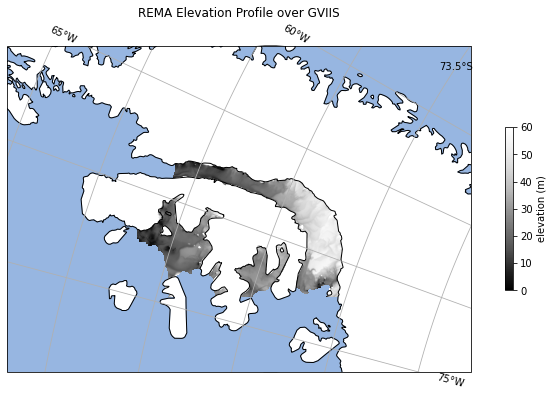

In [77]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1,projection=proj)

ax=plt.axes(projection=proj)
ax.set_extent(GVIIS_extent,ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.OCEAN)

img=ax.imshow(elevation_map.read()[0],cmap='Greys_r',vmin=0,vmax=60)
fig.colorbar(img,ax=ax,shrink=0.5,label='elevation (m)');
show(elevation_map,with_bounds=True,ax=ax,cmap='Greys_r',vmin=0,vmax=60)
ax.set_title('REMA Elevation Profile over GVIIS');

Now, we can extract the x and y coordinates from the geotiff file and put them in an DataArray using the package rioxarray. We can also use the package pyproj to determine the projection of the elevation data.

In [78]:
import rioxarray
import pyproj
from pyproj import Proj,transform
from pyproj.crs import CRS

In [79]:
elev_xarray = rioxarray.open_rasterio('REMA_GVIIS.tif')
elev_xarray

<xarray.DataArray (band: 1, y: 831, x: 1175)>
[976425 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.098e+06 -2.097e+06 ... -1.718e+06 -1.718e+06
  * y            (y) float64 8.302e+05 8.298e+05 ... 5.622e+05 5.618e+05
    spatial_ref  int64 0
Attributes:
    SourceBandIndex:  0
    _FillValue:       -9999.0
    scale_factor:     1.0
    add_offset:       0.0

In [80]:
proj_crs = ccrs.Projection(CRS.from_wkt(elev_xarray.spatial_ref.crs_wkt))
proj_crs

<Projected CRS: PROJCRS["WGS_1984_Antarctic_Polar_Stereographic",B ...>
Name: WGS_1984_Antarctic_Polar_Stereographic
Axis Info [cartesian]:
- [north]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Figure size 360x216 with 0 Axes>

## Part V: Putting it all together
The next step is to combine our elevation data with our radar data so that we can examine the relationship between surface and basal features. For each dataset we made previously using the CReSIS data, we can add in the elevation data at every point along the flight path. This involves converting the (lat,lon) coordinates of the radar data into (x,y) coordinates to align with the elevation data projection, then interpolating the elevation coordinate DataArray to line up with the flight path. This is all done in the for-loop below.

In [81]:
for dataset in dataset_list:
    xyz = proj_crs.transform_points(
        ccrs.PlateCarree(),
        dataset.longitude,
        dataset.latitude
    )
    x_da = xr.DataArray(xyz[:, 0], dims='slow_time')
    y_da = xr.DataArray(xyz[:, 1], dims='slow_time')
    elev_interp = elev_xarray.interp(x=x_da, y=y_da)
    dataset['elev'] = elev_interp

In [82]:
elevation_map=rs.open('REMA_GVIIS.tif')

In [138]:
def plot_flight_line(segment,ax,extent):
    index=segment-1
    dataset=dataset_list[index]
    ax.set_extent(extent,ccrs.PlateCarree())
    ax.coastlines(color='black')
    ax.gridlines(draw_labels=True)
    dataset.plot.scatter('longitude','latitude',transform=ccrs.PlateCarree(),ax=ax)
    ax.scatter(dataset.longitude[0],dataset.latitude[0],transform=ccrs.PlateCarree(),c='red',label='starting point')
    ax.legend()

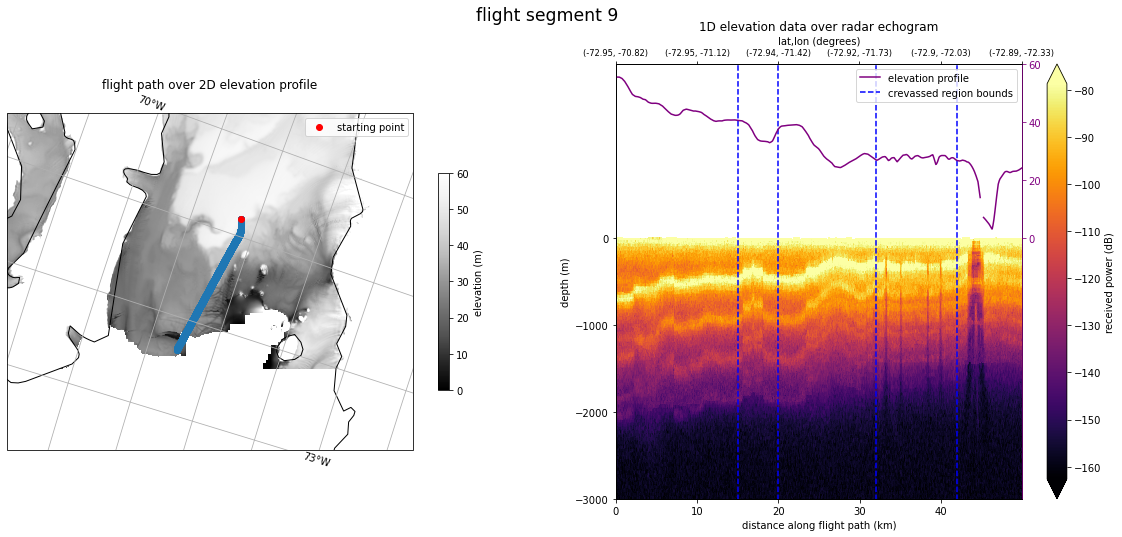

In [139]:
segment=9
index=segment-1
name=name_list[index]
dataset=dataset_list[index]

fig,ax=plt.subplots(1,2,figsize=(20,8))
fig.suptitle(('flight segment '+str(segment)),size='xx-large')

## left plot, flight line over GVIIS
ax[0].remove()
ax0 = fig.add_subplot(1,2,1,projection=proj)
track_extent=[min(dataset.longitude.values)-.5,max(dataset.longitude.values)+.5,min(dataset.latitude.values)-.5,max(dataset.latitude.values)+.5]
plot_flight_line(segment,ax0,track_extent)

## left plot, 2D elevation profile
img=ax0.imshow(elevation_map.read()[0],cmap='Greys_r',vmin=0,vmax=60)
fig.colorbar(img,ax=ax0,shrink=0.5,label='elevation (m)');
show(elevation_map,with_bounds=True,ax=ax0,cmap='Greys_r',vmin=0,vmax=60)
ax0.set_title('flight path over 2D elevation profile')

## right plot, radar echogram
plot_radar_data(segment,ax[1])
ax[1].set_title('1D elevation data over radar echogram')
ax[1].set_ylim(-3000,2000)
ax[1].set_yticks([-3000,-2000,-1000,0])

## right plot, 1D elevation profile
elev_ax=ax[1].twinx()
dataset.where(dataset['elev']>0).elev.plot(x='dist_along_path',ax=elev_ax,color='purple',label='elevation profile')
elev_ax.set_title('')
elev_ax.set_ylim(-90,60)
elev_ax.set_ylabel('')
elev_ax.set_yticks([0,20,40,60])
elev_ax.spines['right'].set_color('purple')
elev_ax.tick_params(axis='y', colors='purple')

elev_ax.vlines((15,20,32,42),-3000,2000,colors=('blue','blue','blue','blue'),linestyle='dashed',label='crevassed region bounds')
elev_ax.legend();

On $\textbf{segment 9:}$ , I've highlighted two regions of basal crevasses with very nearby overlying surface crevasses. The more subtle basal crevasse on the left is mirrored by a similarly more subtle surface crevasse shifted slightly forward along the flight path. The sharper basal crevasses highlighted on the right are also mirrored by sharper surface crevasses.

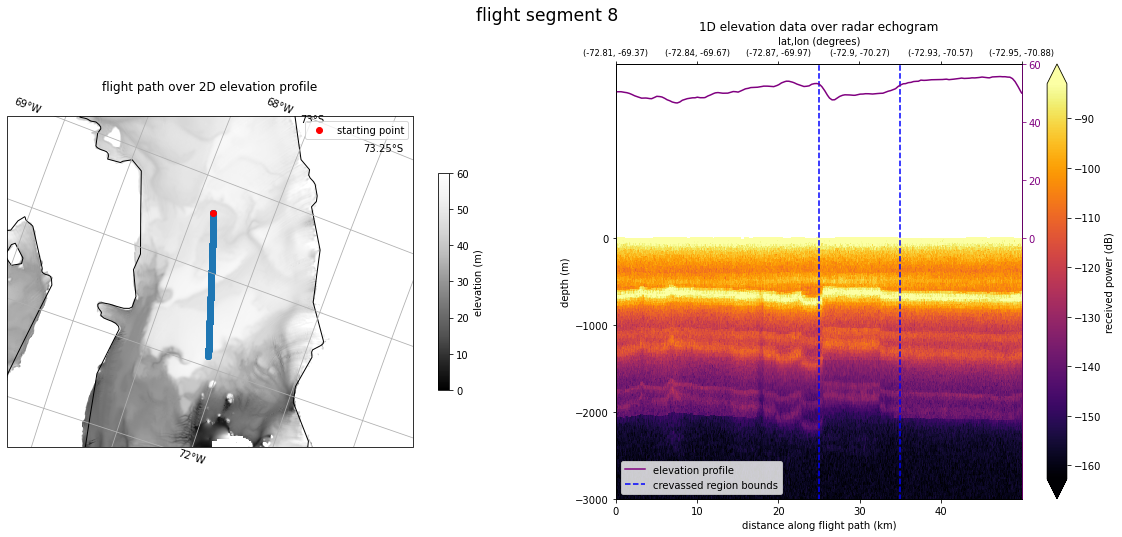

In [140]:
segment=8
index=segment-1
name=name_list[index]
dataset=dataset_list[index]

fig,ax=plt.subplots(1,2,figsize=(20,8))
fig.suptitle(('flight segment '+str(segment)),size='xx-large')

## left plot, flight line over GVIIS
ax[0].remove()
ax0 = fig.add_subplot(1,2,1,projection=proj)
track_extent=[min(dataset.longitude.values)-.5,max(dataset.longitude.values)+.5,min(dataset.latitude.values)-.5,max(dataset.latitude.values)+.5]
plot_flight_line(segment,ax0,track_extent)

## left plot, 2D elevation profile
img=ax0.imshow(elevation_map.read()[0],cmap='Greys_r',vmin=0,vmax=60)
fig.colorbar(img,ax=ax0,shrink=0.5,label='elevation (m)');
show(elevation_map,with_bounds=True,ax=ax0,cmap='Greys_r',vmin=0,vmax=60)
ax0.set_title('flight path over 2D elevation profile')

## right plot, radar echogram
plot_radar_data(segment,ax[1])
ax[1].set_title('1D elevation data over radar echogram')
ax[1].set_ylim(-3000,2000)
ax[1].set_yticks([-3000,-2000,-1000,0])

## right plot, 1D elevation profile
elev_ax=ax[1].twinx()
dataset.where(dataset['elev']>0).elev.plot(x='dist_along_path',ax=elev_ax,color='purple',label='elevation profile')
elev_ax.set_title('')
elev_ax.set_ylim(-90,60)
elev_ax.set_ylabel('')
elev_ax.set_yticks([0,20,40,60])
elev_ax.spines['right'].set_color('purple')
elev_ax.tick_params(axis='y', colors='purple')

elev_ax.vlines((25,35),-3000,2000,colors=('blue','blue'),linestyle='dashed',label='crevassed region bounds')
elev_ax.legend();

Similarly, a shallow basal crevasse on $\textbf{segment 8}$ is mirrored by a similar surface crevasse above it.

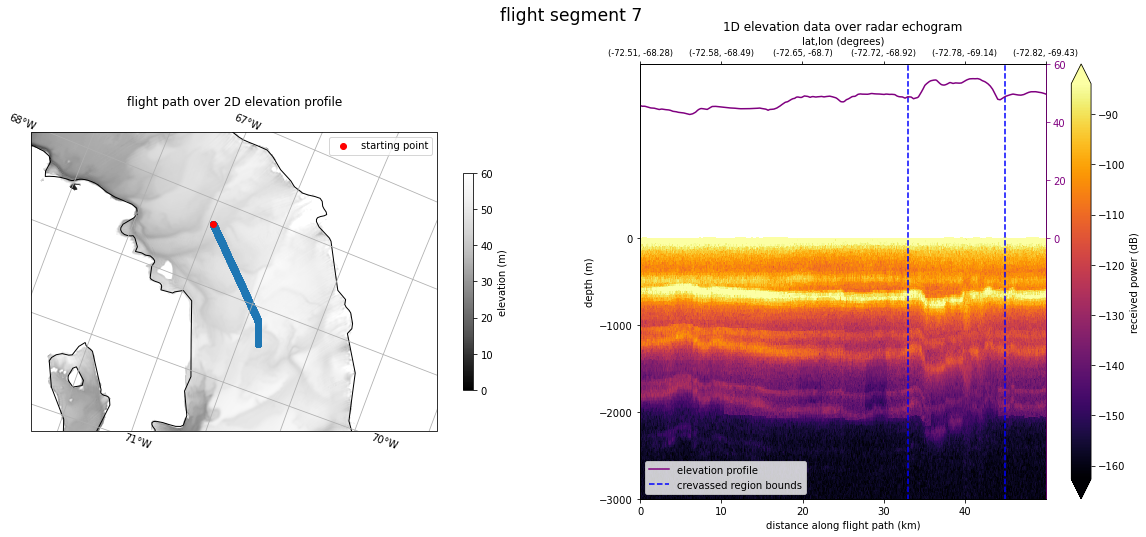

In [141]:
segment=7
index=segment-1
name=name_list[index]
dataset=dataset_list[index]

fig,ax=plt.subplots(1,2,figsize=(20,8))
fig.suptitle(('flight segment '+str(segment)),size='xx-large')

## left plot, flight line over GVIIS
ax[0].remove()
ax0 = fig.add_subplot(1,2,1,projection=proj)
track_extent=[min(dataset.longitude.values)-.5,max(dataset.longitude.values)+.5,min(dataset.latitude.values)-.5,max(dataset.latitude.values)+.5]
plot_flight_line(segment,ax0,track_extent)

## left plot, 2D elevation profile
img=ax0.imshow(elevation_map.read()[0],cmap='Greys_r',vmin=0,vmax=60)
fig.colorbar(img,ax=ax0,shrink=0.5,label='elevation (m)');
show(elevation_map,with_bounds=True,ax=ax0,cmap='Greys_r',vmin=0,vmax=60)
ax0.set_title('flight path over 2D elevation profile')

## right plot, radar echogram
plot_radar_data(segment,ax[1])
ax[1].set_title('1D elevation data over radar echogram')
ax[1].set_ylim(-3000,2000)
ax[1].set_yticks([-3000,-2000,-1000,0])

## right plot, 1D elevation profile
elev_ax=ax[1].twinx()
dataset.where(dataset['elev']>0).elev.plot(x='dist_along_path',ax=elev_ax,color='purple',label='elevation profile')
elev_ax.set_title('')
elev_ax.set_ylim(-90,60)
elev_ax.set_ylabel('')
elev_ax.set_yticks([0,20,40,60])
elev_ax.spines['right'].set_color('purple')
elev_ax.tick_params(axis='y', colors='purple')

elev_ax.vlines((33,45),-3000,2000,colors=('blue','blue'),linestyle='dashed',label='crevassed region bounds')
elev_ax.legend();

$\textbf{Segment 7}$ has no obvious basal crevasses, but does have a region where the ice appears to be thicker both basally and at the surface.

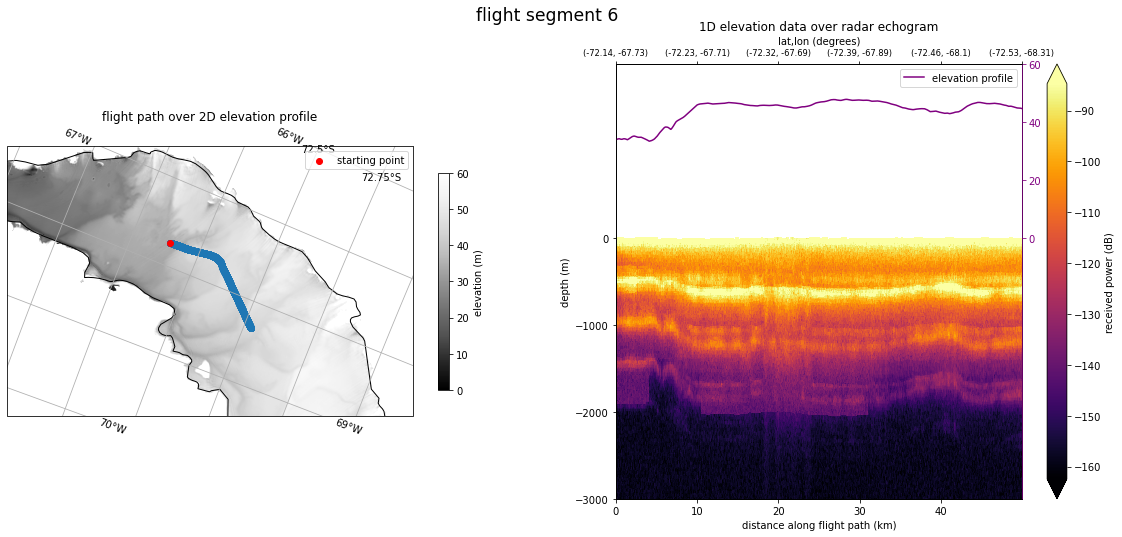

In [142]:
segment=6
index=segment-1
name=name_list[index]
dataset=dataset_list[index]

fig,ax=plt.subplots(1,2,figsize=(20,8))
fig.suptitle(('flight segment '+str(segment)),size='xx-large')

## left plot, flight line over GVIIS
ax[0].remove()
ax0 = fig.add_subplot(1,2,1,projection=proj)
track_extent=[min(dataset.longitude.values)-.5,max(dataset.longitude.values)+.5,min(dataset.latitude.values)-.5,max(dataset.latitude.values)+.5]
plot_flight_line(segment,ax0,track_extent)

## left plot, 2D elevation profile
img=ax0.imshow(elevation_map.read()[0],cmap='Greys_r',vmin=0,vmax=60)
fig.colorbar(img,ax=ax0,shrink=0.5,label='elevation (m)');
show(elevation_map,with_bounds=True,ax=ax0,cmap='Greys_r',vmin=0,vmax=60)
ax0.set_title('flight path over 2D elevation profile')

## right plot, radar echogram
plot_radar_data(segment,ax[1])
ax[1].set_title('1D elevation data over radar echogram')
ax[1].set_ylim(-3000,2000)
ax[1].set_yticks([-3000,-2000,-1000,0])

## right plot, 1D elevation profile
elev_ax=ax[1].twinx()
dataset.where(dataset['elev']>0).elev.plot(x='dist_along_path',ax=elev_ax,color='purple',label='elevation profile')
elev_ax.set_title('')
elev_ax.set_ylim(-90,60)
elev_ax.set_ylabel('')
elev_ax.set_yticks([0,20,40,60])
elev_ax.legend()
elev_ax.spines['right'].set_color('purple')
elev_ax.tick_params(axis='y', colors='purple')

$\textbf{Segment 6}$ has no immediately obvious basal features.

## Part VI: Results summary
From looking qualitatively at these plots, there definitely appears to be a strong correlation between surface and basal crevasses. Segments 8 and 9 have signatures of surface and basal crevasses right on top of one another. Segment 7 has other mirrored features, and segment 6 appears to be relatively smooth both basally and at the surface. Furthermore, the size and shape of basal crevasses appears to be similar to the size and shape of the overlying surface crevasses.

## Part VII: Possible future steps
Given that the basal and surface data was extracted from two entirely different datasets, it was very cool to see how well these features line up. I'm looking forward to working more with this data in the future. Some ideas include:
- Write a script to automatically find the ice-ocean interface from an echogram
- Modify that script to also find basal crevasse locations and sizes.
- Use the spatial lag between surface and basal features, along with the timespan in between data collections, to try and determine ice velocity values.
- Find the correlation between the sizes of basal and overlying surface crevasses.
- So much more!

## "Appendix": Code graveyard

In [22]:
#from osgeo import gdal
#gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL','YES')
#from geopy import distance
#import cartopy.feature as cfeature

In [23]:
#data_vars={'data':(['slow_time','fast_time'],arrays.get('Data'))}

#coords={
#        'slow_time':arrays.get('GPS_time').flatten(),
#        'fast_time':arrays.get('Time').flatten(),
#        'latitude':(['slow_time'],arrays.get('Latitude').flatten()),
#        'longitude':(['slow_time'],arrays.get('Longitude').flatten()),
#        'elevation':(['slow_time'],arrays.get('Elevation').flatten()),
#        'surface':(['slow_time'],arrays.get('Surface').flatten()),
#        'bottom':(['slow_time'],arrays.get('Bottom').flatten())
#}

In [24]:
#DC8_2018_1112_04_010 = xr.Dataset(
#    data_vars=data_vars,
#    coords=coords
#)

#DC8_2018_1112_04_010=DC8_2018_1112_04_010.assign(log_data=lambda DC8_2018_1112_04_010: 10 * np.log10(DC8_2018_1112_04_010.data))
#DC8_2018_1112_04_010=DC8_2018_1112_04_010.assign_coords(depth=lambda DC8_2018_1112_04_010: DC8_2018_1112_04_010.elevation - DC8_2018_1112_04_010.fast_time * c/2)

In [25]:
#arrays = {}
#for k,v in DC8_2018_1112_04_010_h5.items():
#    arrays[k] = np.array(v)

In [26]:
#def dist_from_start(start_lat,start_lon,end_lat,end_lon):
#    starting_point=(start_lat,start_lon)
#    ending_point=(end_lat,end_lon)
#    dist = distance.distance(ending_point,starting_point).meters
#    return dist

In [27]:
#dataset=dataset_list[0]
#distances = np.array([])
#start_lat = dataset.latitude.values[0]
#start_lon = dataset.longitude.values[0]

#for i in np.arange(len(dataset.latitude.values)):
#    end_lat=dataset.latitude.values[i]
#    end_lon=dataset.longitude.values[i]
#    dist=dist_from_start(start_lat,start_lon,end_lat,end_lon)
#    distances=np.append(distances,dist)

In [28]:
# failed attempt to extract 1D elevation profile

# converting lat, lon coordinates in dataset to x,y coordinates
#inProj=Proj(init='epsg:4326') # WGS 84 (lat,lon)
#outProj=Proj(init='epsg:3031') # Antarctic Polar Stereographic

#xs=np.array([])
#ys=np.array([])

#for i in np.arange(len(dataset.latitude.values)):
#    lat=dataset.latitude.values[i]
#    lon=dataset.longitude.values[i]
#    x,y=transform(inProj,outProj,lat,lon)
#    xs=np.append(xs,x)
#    ys=np.append(ys,y)
    
#x_coords=np.array([])
#y_coords=np.array([])

#for i in np.arange(elevation_map.height):
#    for j in np.arange(elevation_map.width):
#        x_elev,y_elev=elevation_map.xy(i,j)
#        x_coords=np.append(x_coords,x_elev)
#        y_coords=np.append(y_coords,y_elev)
        
#for x in xs,y in ys:
#    xidx = (np.abs(x_coords - x)).argmin()
#    yidx = (np.abs(y_coords - y)).argmin()

In [29]:
#with rs.open('REMA_GVIIS.tif') as elev_dataset:
#    elev_val=elev_dataset.read(1)
#    no_data=elev_dataset.nodata
#    elev_data=[(elev_dataset.xy(x,y)[0],elev_dataset.xy(x,y)[1],elev_val[x,y]) for x,y in np.ndindex(elev_val.shape) if elev_val[x,y] != no_data]
#    x=[i[0] for i in elev_data]
#    y=[i[1] for i in elev_data]
#    elev=[i[2] for i in elev_data]

#def xy_to_lonlat(x,y):
#    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
#    proj_xy = pyproj.Proj('epsg:3031') # Antarctic Polar Stereographic
#    lonlat=pyproj.transform(proj_xy,proj_latlon,x,y)
#    return lonlat[0],lonlat[1]

#lon_elev=xy_to_lonlat(x,y)[0]
#lat_elev=xy_to_lonlat(x,y)[1]

In [30]:
#g0=griddata((lon_elev,lat_elev),elev,(dataset.longitude.values,dataset.latitude.values),method='nearest')
#dataset=dataset.assign({'elevation_data':g0})

In [31]:
        #"2018_Antarctica_DC8/CSARP_mvdr/20181112_04/Data_img_02_20181112_04_020.mat":None,
        #"2011_Antarctica_DC8/CSARP_mvdr/20111119_03/Data_20111119_03_001.mat":None
        #"2018_Antarctica_DC8/CSARP_mvdr/20181013_01/Data_20181013_01_053.mat":None,
        #"2018_Antarctica_DC8/CSARP_mvdr/20181013_01/Data_20181013_01_054.mat":None,
        #"2018_Antarctica_DC8/CSARP_mvdr/20181013_01/Data_20181013_01_055.mat":None,
        #"2018_Antarctica_DC8/CSARP_mvdr/20181013_01/Data_20181013_01_056.mat":None,

In [32]:
# index=4
# name=name_list[index]
# dataset=dataset_list[index]

# fig = plt.figure()
# gs = fig.add_gridspec(4, 20)

# fig.suptitle(name,fontsize='xx-large')

# ax1 = fig.add_subplot(gs[0:2,0:8],projection=proj)
# ax1.set_extent(extent,ccrs.PlateCarree())
# ax1.coastlines(color='blue')
# ax1.gridlines(draw_labels=True)
# ax1.scatter(dataset.longitude,dataset.latitude,transform=ccrs.PlateCarree())
# ax1.scatter(dataset.longitude[0],dataset.latitude[0],transform=ccrs.PlateCarree(),c='red',label='starting point')
# ax1.legend(loc='lower right',fontsize=18)
# ax1.set_title('flight path')

# ax2 = fig.add_subplot(gs[0:2,10:20])
# ax2.set_ylim(-4000,500)
# dataset.log_data.plot(x='dist_along_path',y='depth',ax=ax2,cmap='inferno',cbar_kwargs={'label':'received power (dB)'})
# ax2.set_xlabel('distance along flight path (km)')
# ax2.set_xticks(np.arange(0,51,10))

# secax=ax2.twiny()
# indices=np.append(np.arange(0,len(dataset.lat_lon.values),round(len(dataset.lat_lon.values)/5)),len(dataset.latitude.values)-1)
# secax.set_xticklabels(dataset.lat_lon.values[indices])
# secax.set_xlabel('lat,lon (degrees)')
# ax2.set_ylabel('depth (m)')
# ax2.set_title('radar echogram');

# extent_track=[min(dataset.longitude.values),max(dataset.longitude.values),min(dataset.latitude.values),max(dataset.latitude.values)]
# ax3=fig.add_subplot(gs[2:3,0:10],projection=proj)
# extent_track=[min(dataset.longitude.values)-.1,max(dataset.longitude.values)+.1,min(dataset.latitude.values)-.1,max(dataset.latitude.values)+.1]
# ax3.set_extent(extent_track,ccrs.PlateCarree())
# ax3.coastlines(color='blue')
# ax3.gridlines(draw_labels=True);

# img=ax3.imshow(elevation_map.read()[0],cmap='Greys_r',vmin=-10,vmax=70)
# fig.colorbar(img,ax=ax3,shrink=0.5,label='elevation (m)');
# show(elevation_map,with_bounds=True,ax=ax3,cmap='Greys_r',vmin=-10,vmax=70)
# ax3.scatter(dataset.longitude,dataset.latitude,transform=ccrs.PlateCarree())
# ax3.scatter(dataset.longitude[0],dataset.latitude[0],transform=ccrs.PlateCarree(),c='red',label='starting point',s=100)
# ax3.set_title('elevation profile');

In [ ]:
# segment=9
# index=segment-1
# name=name_list[index]
# dataset=dataset_list[index]

# fig,ax=plt.subplots(2,2,figsize=(20,14))
# fig.suptitle(name,fontsize='xx-large')

# ## upper left plot, flight line over GVIIS
# ax[0,0].remove()
# ax0 = fig.add_subplot(2,2,1,projection=proj)
# plot_flight_line(segment,ax0,GVIIS_extent)
# ax0.legend(loc='lower right',fontsize=18)
# ax0.set_title('flight path')

# ## upper right plot, radar echogram
# plot_radar_data(9,ax[0,1])
# ax[0,1].set_title('radar echogram');

# ## upper right plot, 1D elevation profile
# elev_ax=ax[0,1].twinx()
# dataset.where(dataset['elev']!=-9999).elev.plot(x='dist_along_path',ax=elev_ax)
# elev_ax.set_title('')
# elev_ax.set_ylim(0,100);

# ## lower left plot, flight line over GVIIS
# ax[1,0].remove()
# ax2 = fig.add_subplot(2,2,3,projection=proj)
# track_extent=[min(dataset.longitude.values)-.1,max(dataset.longitude.values)+.1,min(dataset.latitude.values)-.1,max(dataset.latitude.values)+.1]
# plot_flight_line(segment,ax2,track_extent)

# ## lower left plot, 2D elevation profile
# img=ax2.imshow(elevation_map.read()[0],cmap='Greys_r',vmin=0,vmax=60)
# fig.colorbar(img,ax=ax2,shrink=0.5,label='elevation (m)');
# show(elevation_map,with_bounds=True,ax=ax2,cmap='Greys_r',vmin=0,vmax=60)
# ax2.set_title('2D elevation profile')

# ## lower right plot, 1D elevation profile
# dataset.elev.plot(x='dist_along_path',ax=ax[1,1])
# ax[1,1].set_xlabel('distance along flight path (km)')
# ax[1,1].set_title('1D elevation profile along flight path')
# ax[1,1].set_ylim(0,60);